# Setting up

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fastai import *
from fastai.tabular import *

%matplotlib inline
sns.set(style = "whitegrid")
pd.set_option('display.max_columns', 500)

In [ ]:
# %%time
# path = 'D://Coding//XTX Forecasting Challenge//data-training.csv'
# df = pd.read_csv(path)

In [5]:
%%time
path = 'D://Coding//XTX Forecasting Challenge//data-training.file'
df = pd.read_feather(path, use_threads=8)
df = df.astype('float32')

Wall time: 7.18 s


In [6]:
df.columns

Index(['askRate0', 'askRate1', 'askRate2', 'askRate3', 'askRate4', 'askRate5',
       'askRate6', 'askRate7', 'askRate8', 'askRate9', 'askRate10',
       'askRate11', 'askRate12', 'askRate13', 'askRate14', 'askSize0',
       'askSize1', 'askSize2', 'askSize3', 'askSize4', 'askSize5', 'askSize6',
       'askSize7', 'askSize8', 'askSize9', 'askSize10', 'askSize11',
       'askSize12', 'askSize13', 'askSize14', 'bidRate0', 'bidRate1',
       'bidRate2', 'bidRate3', 'bidRate4', 'bidRate5', 'bidRate6', 'bidRate7',
       'bidRate8', 'bidRate9', 'bidRate10', 'bidRate11', 'bidRate12',
       'bidRate13', 'bidRate14', 'bidSize0', 'bidSize1', 'bidSize2',
       'bidSize3', 'bidSize4', 'bidSize5', 'bidSize6', 'bidSize7', 'bidSize8',
       'bidSize9', 'bidSize10', 'bidSize11', 'bidSize12', 'bidSize13',
       'bidSize14', 'y'],
      dtype='object')

# Exploratory Data Analysis

In [ ]:
# # Plot of [y] distribution
# fig, ax = plt.subplots(figsize=(15,8))
# sns.kdeplot(df.y, bw=0.01)

In [ ]:
# Some feature engineering
df.fillna(0, inplace=True)
df['spread'] = df.askRate0 - df.bidRate0
df['midRate'] = (df.askRate0 + df.bidRate0) / 2
# df['expectedY'] = df.midRate.diff(87).shift(-87).clip(-5,5)

In [ ]:
# # Figuring out what [y] is
# # y(t) is midRate(t+87) - midRate(t), clipped to (-5.5)
# sum(df.y == df.expectedY)
# df.loc[df.y != df.expectedY]

# fig, ax = plt.subplots(figsize=(15,8))
# i = 500
# shift = 87
# # plt.plot(df.index[0:i], df.midRate[0:i].diff(shift).shift(-shift+14))
# plt.plot(df.index[-i:], df.midRate[-i:].diff(shift).shift(-shift))
# plt.plot(df.index[-i:], df.y[-i:])
# plt.legend(('midRate', 'y'))

# Feature engineering

### Basics

In [1]:
bidSizeList = ['bidSize' + str(i) for i in range(0,15)]
askSizeList = ['askSize' + str(i) for i in range(0,15)]
bidRateList = ['bidRate' + str(i) for i in range(0,15)]
askRateList = ['askRate' + str(i) for i in range(0,15)]

In [ ]:
df['totalBidVol1'] = df.bidSize0 + df.bidSize1
for i in range(2,15):
    df['totalBidVol' + str(i)] = df['totalBidVol' + str(i-1)] + df['bidSize' + str(i)]

df['totalAskVol1'] = df.askSize0 + df.askSize1
for i in range(2,15):
    df['totalAskVol' + str(i)] = df['totalAskVol' + str(i-1)] + df['askSize' + str(i)]
    
for i in range(1,15):
    df['bidAskRatio' + str(i)] = df['totalBidVol' + str(i)] / df['totalAskVol' + str(i)]

df['totalAvailVol'] = df.totalBidVol14 + df.totalAskVol14

In [ ]:
df['vwaBid'] = np.einsum('ij,ji->i', df[bidRateList], df[bidSizeList].T) / df[bidSizeList].sum(axis=1)
df['vwaAsk'] = np.einsum('ij,ji->i', df[askRateList], df[askSizeList].T) / df[askSizeList].sum(axis=1)
df['vwaBidDMid'] = df.midRate - df.vwaBid
df['vwaAskDMid'] = df.vwaAsk - df.midRate
df['diff_vwaBidAskDMid'] = df.vwaAskDMid - df.vwaBidDMid

# Ideas from papers

In [ ]:
# Volume Order Imbalance
# I still disagree with cancelled orders..
b1, a1 = (df.bidRate0 < df.bidRate0.shift(-1)), (df.askRate0 < df.askRate0.shift(-1))
b2, a2 = (df.bidRate0 == df.bidRate0.shift(-1)), (df.askRate0 == df.askRate0.shift(-1))
valsB, valsA = [0, (df.bidSize0 - df.bidSize0.shift(-1))], [0, (df.askSize0 - df.askSize0.shift(-1))]
defaultB, defaultA = df.bidSize0, df.askSize0

df['deltaVBid'] = np.select([b1,b2], valsB, default=defaultB)
df['deltaVAsk'] = np.select([a1,a2], valsA, default=defaultA)
df['VOI'] = df.deltaVBid - df.deltaVAsk

# Order Imbalance Ratio: when OIR is small, suggests that signal from VOI is weak
df['OIR'] = (df.bidSize0 - df.askSize0)/(df.bidSize0 + df.askSize0)

In [ ]:
df.to_feather('intermediate.file')

In [ ]:
# drop original features
df.drop(df.columns[:60], axis=1, inplace=True)

In [2]:
df = pd.read_feather('intermediate.file')

# Fast.ai

In [3]:
dep_var = 'y'
procs = [FillMissing, Normalize]

In [4]:
path = f'D:\Coding\XTX Forecasting Challenge'
data = TabularDataBunch.from_df(path = path, df = df[:int(5e5)], dep_var = 'y', procs=procs,
                                 valid_idx = list(range(int(4e5),int(5e5))))

In [ ]:
data.show_batch(rows=10)

In [ ]:
# data = (TabularList.from_df(df[:int(5e5)], cont_names=df.columns, procs=procs)
#                            .split_by_idx(list(range(int(0.8*5e5),int(5e5))))
#                            .label_from_df(cols=dep_var, label_cls=FloatList)
#                            .databunch())

In [29]:
learn = tabular_learner(data, layers=[500,200], metrics=r2_score, ps=[0.001,0.01], emb_drop=0.04)

In [30]:
learn.model

TabularModel(
  (embeds): ModuleList()
  (emb_drop): Dropout(p=0.04, inplace=False)
  (bn_cont): BatchNorm1d(114, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=114, out_features=500, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.001, inplace=False)
    (4): Linear(in_features=500, out_features=200, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.01, inplace=False)
    (8): Linear(in_features=200, out_features=1, bias=True)
  )
)

In [11]:
learn.lr_find(end_lr=1e1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


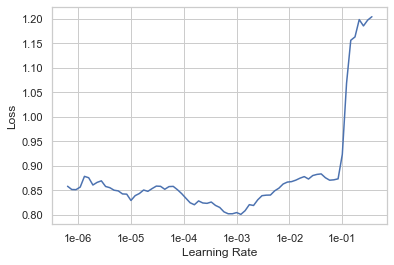

In [12]:
learn.recorder.plot()

In [ ]:
# model above has already diverged, we will restart.

In [31]:
learn.fit_one_cycle(3, 1e-4, wd=0.1)

epoch,train_loss,valid_loss,r2_score,time
0,0.568406,0.641813,-inf,04:21
1,0.488415,0.786832,-inf,04:18
2,0.479876,0.695911,-inf,04:06


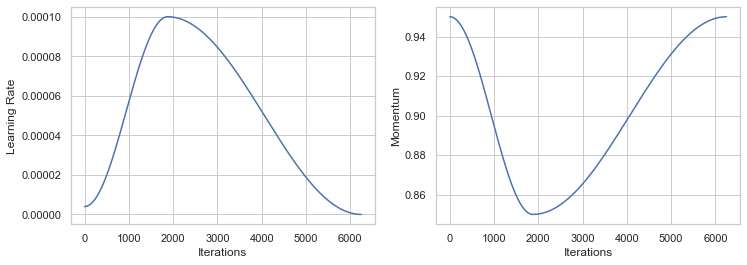

In [14]:
learn.recorder.plot_lr(show_moms=True)

In [32]:
learn.save('new_fastai')

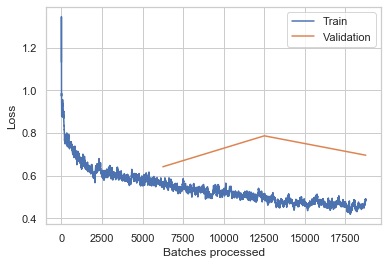

In [33]:
learn.recorder.plot_losses()

In [38]:
learn.predict(df.iloc[int(8.1e5)])

(FloatItem [0.449099], tensor([0.4491]), tensor([0.4491]))

In [39]:
df.y.iloc[int(8.1e5)]

0.25

In [40]:
preds = learn.get_preds()

# TA

In [ ]:
# Rolling ohlc
df_ask = df.askRate0.to_frame()
df_ask['openAsk'] = df_ask.askRate0.shift(15-1)
df_ask['highAsk'] = df_ask.askRate0.rolling(window=15).max().fillna(0)
df_ask['lowAsk'] = df_ask.askRate0.rolling(window=15).min().fillna(0)
df_ask = df_ask[['openAsk','highAsk','lowAsk','askRate0']].join(df.askSize0)

df_bid = df.bidRate0.to_frame()
df_bid['openBid'] = df_bid.bidRate0.shift(15-1)
df_bid['highBid'] = df_bid.bidRate0.rolling(window=15).max().fillna(0)
df_bid['lowBid'] = df_bid.bidRate0.rolling(window=15).min().fillna(0)
df_bid = df_bid[['openBid','highBid','lowBid','bidRate0']].join(df.bidSize0)

In [ ]:
import ta
df_ask_ta = ta.add_all_ta_features(df_ask, "openAsk", "highAsk", "lowAsk", "askRate0", "askSize0", fillna=True)


In [ ]:
df_bid_ta = ta.add_all_ta_features(df_ask, "openBid", "highBid", "lowBid", "askRate0", "bidRate0", fillna=True)

# Feature Selection

In [3]:
%%time
X = df.drop('y', axis=1).values
# X = df.drop('y', axis=1).iloc[:,indices[:50]].values
y = df.y.values

Wall time: 1.13 s


In [55]:
# normalise
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# pca
from sklearn.decomposition import PCA
pca = PCA(n_components=30)
X_pca = pca.fit_transform(X_scaled)

# Cross-validation

In [16]:
%%time
# for regression
X = df.drop('y', axis=1).values
# X = df.drop('y', axis=1).iloc[:,indices[:50]].values
y = df.y.values

Wall time: 1.25 s


In [108]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from rolling import RollingWindowSplit

rlcv = RollingWindowSplit(n_splits=5, compatible=True)
for inc, (train_index, valid_index) in enumerate(rlcv.split(X), 1):
    x_train, x_valid = X[train_index], X[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]
    print("TRAIN:", (train_index[0], train_index[-1]),
          "VALID:", (valid_index[0], valid_index[-1]),
          "SIZES:", (len(x_train), len(x_valid)))
    
lasso = LassoLarsCV(cv=rlcv, n_jobs=-1).fit(X, y)

TRAIN: (2, 428572) VALID: (428573, 857143) SIZES: (428571, 428571)
TRAIN: (428573, 857143) VALID: (857144, 1285714) SIZES: (428571, 428571)
TRAIN: (857144, 1285714) VALID: (1285715, 1714285) SIZES: (428571, 428571)
TRAIN: (1285715, 1714285) VALID: (1714286, 2142856) SIZES: (428571, 428571)
TRAIN: (1714286, 2142856) VALID: (2142857, 2571427) SIZES: (428571, 428571)


In [57]:
print(pca.explained_variance_ratio_)

[0.339363 0.148498 0.112511 0.038578 0.030945 0.02155  0.02029  0.019281 0.018302 0.0176   0.015209 0.014452 0.01338
 0.011426 0.009937 0.00914  0.00901  0.008673 0.008383 0.008    0.007726 0.007239 0.007173 0.00712  0.006848 0.006796
 0.006497 0.006261 0.006212 0.006134]


# Lasso

In [ ]:
# LASSO regression
from sklearn.linear_model import LassoLarsCV
lasso = LassoLarsCV(cv=rlcv, n_jobs=-1).fit(X, y)
print(f'{lasso.score(x_train, y_train):.3f}, {lasso.score(x_valid, y_valid):.3f}')

In [ ]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from rolling import RollingWindowSplit
from joblib import dump, load

rlcv = RollingWindowSplit(n_splits=5, compatible=True)
for inc, (train_index, valid_index) in enumerate(rlcv.split(X), 1):
    x_train, x_valid = X[train_index], X[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]
    print("TRAIN:", (train_index[0], train_index[-1]),
          "VALID:", (valid_index[0], valid_index[-1]),
          "SIZES:", (len(x_train), len(x_valid)))

In [108]:
lasso = LassoLarsCV(cv=rlcv, n_jobs=-1).fit(X, y)
dump(lasso, f'lasso_rlcv_114ft_0.0175_0.0187.joblib')

TRAIN: (2, 428572) VALID: (428573, 857143) SIZES: (428571, 428571)
TRAIN: (428573, 857143) VALID: (857144, 1285714) SIZES: (428571, 428571)
TRAIN: (857144, 1285714) VALID: (1285715, 1714285) SIZES: (428571, 428571)
TRAIN: (1285715, 1714285) VALID: (1714286, 2142856) SIZES: (428571, 428571)
TRAIN: (1714286, 2142856) VALID: (2142857, 2571427) SIZES: (428571, 428571)


In [108]:
print(f'{lasso.score(x_train, y_train):.4f}, {lasso.score(x_valid, y_valid):.4f}')

TRAIN: (2, 428572) VALID: (428573, 857143) SIZES: (428571, 428571)
TRAIN: (428573, 857143) VALID: (857144, 1285714) SIZES: (428571, 428571)
TRAIN: (857144, 1285714) VALID: (1285715, 1714285) SIZES: (428571, 428571)
TRAIN: (1285715, 1714285) VALID: (1714286, 2142856) SIZES: (428571, 428571)
TRAIN: (1714286, 2142856) VALID: (2142857, 2571427) SIZES: (428571, 428571)


In [7]:
# dump(lasso, 'lasso_rlcv_114ft_0.0175_0.0187.joblib')

In [104]:
lasso = load('lasso_rlcv_114ft_0.0175_0.0187.joblib') 

0.0175, 0.0187


In [110]:
sigmoid = (1/(1+np.exp(-0.22*lasso.predict(x_valid)))-0.5)*20

In [111]:
r2d2(y_valid, sigmoid)

0.01894224448898718

In [15]:
from sklearn.metrics import r2_score as r2d2

In [103]:
r2d2(y_valid, lasso.predict(x_valid))

0.02102596287515801

In [81]:
lasso.predict(np.atleast_2d(df.iloc[0].drop('y').to_list()))

array([0.138818])

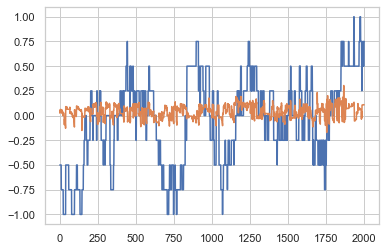

In [26]:
plt.plot(y_valid[:2000])
plt.plot(sigmoid[:2000])

# RF

In [ ]:
# Create the random grid
random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 10, stop = 500, num = 10)],
               'max_features': ['auto', 'sqrt'],
               'max_depth': [None, *[int(x) for x in np.linspace(10, 110, num = 11)]],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4]}

In [ ]:
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,
                               n_iter = 30, cv = rlcv, verbose=2, random_state=42, n_jobs=-1)

In [ ]:
rf_random.fit(X, y)

In [ ]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(15,8))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [ ]:
# scores
print(f'{rf.score(x_train, y_train):.3f}, {rf.score(x_valid, y_valid):.3f}')

In [ ]:
# do some rounding of continuous values
def rounding(number):
    return np.round(number * 4, decimals=0) / 4
rpredictions = rounding(predictions)

In [ ]:
dump(importances, 'importances.joblib')

In [ ]:
importances = load('importances.joblib')

In [ ]:
# save model
from joblib import dump, load
dump(rf, 'model.joblib')

In [ ]:
# load model
rf2 = load('model.joblib')
rf2.score(x_valid, y_valid)